In [1]:
%matplotlib inline

We use the Quickstart tutorial from PyTorch ([link](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)) for our example.

In [2]:
from pathlib import Path
import logging
import sys
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sniper import SniperTraining
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


We have modified the learning rate for faster convergence, so that we can see how SNIPER works.

In [7]:
loss_fn = nn.CrossEntropyLoss()
optim_lr = 0.03

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    # size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc = correct / size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_acc, test_loss

We will use this `run_train_test` for both SNIPER training and normal training. The `hooks` are for us to add callables for SNIPER (we'll see this later).

In [10]:
def run_train_test(model, loss_fn, optimizer, epochs, hooks=()):
    losses = []
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_acc, test_loss = test(test_dataloader, model, loss_fn)
        losses.append((epoch, test_acc, test_loss))
        for hook in hooks:
            hook()
    return np.array(losses)

In [11]:
# Set SNIPER global logger
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(stream=sys.stdout))
logger.setLevel(logging.INFO)

In [12]:
# Set working folder
sniper_dir = Path('masks')
sniper = SniperTraining(sniper_dir=sniper_dir, logger=logger)

For simplicity, let us try setting a constant 80% sparsity first, and we will compare with the variable-sparsity training later.

In [13]:
# Define sparsity schedule with {epoch: sparsity %}
schedule = {0: 80}

# Define variables needed for SNIPER training
model_builder = NeuralNetwork
snip_module_name = ''
batch_iterator = train_dataloader
def get_loss_fn(model, batch):
    X, y = batch
    X, y = X.to(device), y.to(device)
    pred = model(X)
    return loss_fn(pred, y)

The optimizer needs to accept the param groups from `sniper` to modify learning rates. If you do not have a scheduler, `sniper` will **directly** modify the learning rates during sparsity changes. If you have a scheduler, you need to set it in `sniper` to change  `base_lrs` when sparsity changes.

In [14]:
params = model.parameters() if sniper.param_groups is None else sniper.param_groups
optimizer = torch.optim.SGD(params, lr=optim_lr)
print(optimizer)
sniper.optimizers = [optimizer]
# sniper.schedulers = [scheduler]  # if you are using a scheduler

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


This is a minimal example; there are more options such as setting maximum sparsity of parameters (see documentation on `sniper.train()` for more info).

In [17]:
def sniper_train_test(sniper, schedule, optim_lr, loss_fn, epochs):
    model = NeuralNetwork().to(device)

    # This will save model initial values, and the masks of the scheduled sparsities, in `masks`.
    sniper.train(
        schedule=schedule,
        model=model,
        model_builder=model_builder,
        snip_module_name=snip_module_name,
        batch_iterator=batch_iterator,
        get_loss_fn=get_loss_fn,
        optim_lr=optim_lr,
    )
    params = model.parameters() if sniper.param_groups is None else sniper.param_groups
    optimizer = torch.optim.SGD(params, lr=optim_lr)
    print(optimizer)
    sniper.optimizers = [optimizer]
    # sniper.schedulers = [scheduler]  # if you are using a scheduler

    # Add `sniper.step()` to your training loop.
    losses = run_train_test(model, loss_fn, optimizer, epochs=epochs, hooks=[sniper.step])
    return losses

In [18]:
sparsity80_losses = sniper_train_test(sniper, schedule, optim_lr=optim_lr, loss_fn=loss_fn, epochs=40)

Loading initial model state from masks/init_values.pt
All required sparsities present, loading sparsity 80...
Loaded mask from masks/masks_80.pt
Adding mask operation to forward hook...
Creating optimizer learning rates...
SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1473417349810351
    maximize: False
    momentum: 0
    name: linear_relu_stack.0.weight
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    lr: 0.07314285714285715
    maximize: False
    momentum: 0
    name: linear_relu_stack.0.bias
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    foreach: None
    lr: 0.16155799334401577
    maximize: False
    momentum: 0
    name: linear_relu_stack.2.weight
    nesterov: False
    weight_decay: 0

Parameter Group 3
    dampening: 0
    foreach: None
    lr: 0.05525179856115108
    maximize: False
    momentum: 0
    name: linear_relu_stack.2.bias
    nesterov: False
    weight_decay:

In [19]:
torch.save(model.state_dict(), "sparsity80_model.pth")

Compare this to the normally trained model.

In [21]:
model = NeuralNetwork().to(device)
init_values = torch.load(sniper_dir / 'init_values.pt', map_location=device)
model.load_state_dict(init_values)
optimizer = torch.optim.SGD(model.parameters(), lr=optim_lr)
normal_losses = run_train_test(model, loss_fn, optimizer, epochs=40)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.644728 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.567345 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.522061 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.490036 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.462711 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.435538 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.422167 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.409252 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.396777 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.389979 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 86.1%, Avg los

In [22]:
torch.save(model.state_dict(), "original_model.pth")

Let's plot the losses.

<Figure size 640x480 with 0 Axes>

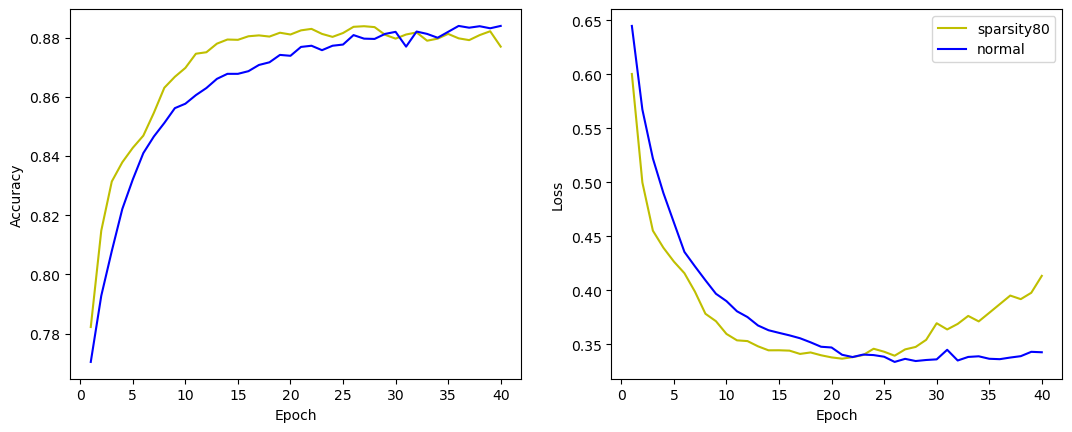

In [29]:
width, height = plt.figure().get_size_inches()
plt.figure(figsize=(width*2, height))

# Test accuracy
plt.subplot(1, 2, 1)
plt.plot(sparsity80_losses[:, 0], sparsity80_losses[:, 1], 'y', label='sparsity80')
plt.plot(normal_losses[:, 0], normal_losses[:, 1], 'b', label='normal')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Test loss
plt.subplot(1, 2, 2)
plt.plot(sparsity80_losses[:, 0], sparsity80_losses[:, 2], 'y', label='sparsity80')
plt.plot(normal_losses[:, 0], normal_losses[:, 2], 'b', label='normal')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

We can see that 80% sparsity model (with SNIPER scaling the parameter learning rates according to each layer's sparsity) learns faster at the start but it hits maximum performance earlier than normal training. Combining both is the idea behind variable-rate training. Let's decay the sparsity in an approximately exponential way, and train again.

In [25]:
schedule = {0: 80,
            5: 40,
            10: 20,
            15: 10,
            20: 0}

In [26]:
sniper_losses = sniper_train_test(sniper, schedule, optim_lr=optim_lr, loss_fn=loss_fn, epochs=40)

Loading initial model state from masks/init_values.pt
All required sparsities present, loading sparsity 80...
Loaded mask from masks/masks_80.pt
Adding mask operation to forward hook...
Creating optimizer learning rates...
SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1473417349810351
    maximize: False
    momentum: 0
    name: linear_relu_stack.0.weight
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    lr: 0.07314285714285715
    maximize: False
    momentum: 0
    name: linear_relu_stack.0.bias
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    foreach: None
    lr: 0.16155799334401577
    maximize: False
    momentum: 0
    name: linear_relu_stack.2.weight
    nesterov: False
    weight_decay: 0

Parameter Group 3
    dampening: 0
    foreach: None
    lr: 0.05525179856115108
    maximize: False
    momentum: 0
    name: linear_relu_stack.2.bias
    nesterov: False
    weight_decay:

In [27]:
torch.save(model.state_dict(), "sniper_model.pth")

Compare the losses now. We have the best of both worlds!

<Figure size 640x480 with 0 Axes>

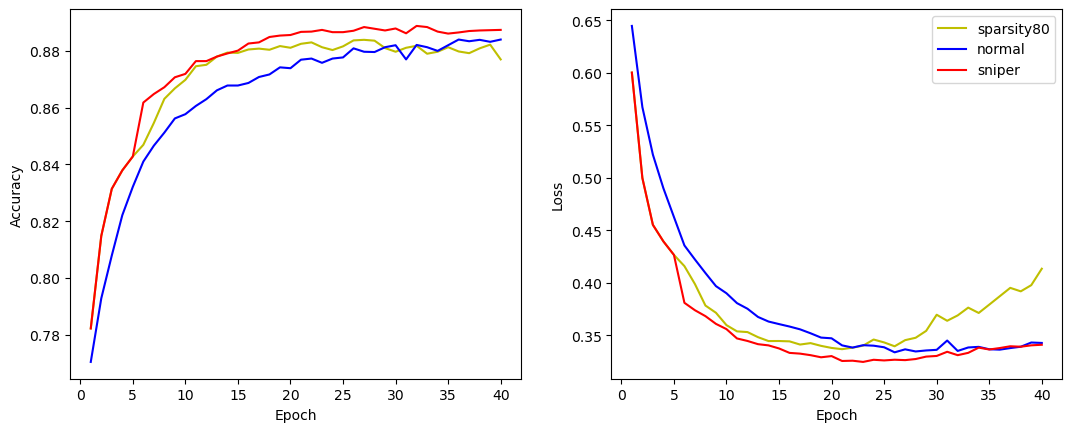

In [30]:
width, height = plt.figure().get_size_inches()
plt.figure(figsize=(width*2, height))

# Test accuracy
plt.subplot(1, 2, 1)
plt.plot(sparsity80_losses[:, 0], sparsity80_losses[:, 1], 'y', label='sparsity80')
plt.plot(normal_losses[:, 0], normal_losses[:, 1], 'b', label='normal')
plt.plot(sniper_losses[:, 0], sniper_losses[:, 1], 'r', label='sniper')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Test loss
plt.subplot(1, 2, 2)
plt.plot(sparsity80_losses[:, 0], sparsity80_losses[:, 2], 'y', label='sparsity80')
plt.plot(normal_losses[:, 0], normal_losses[:, 2], 'b', label='normal')
plt.plot(sniper_losses[:, 0], sniper_losses[:, 2], 'r', label='sniper')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()